## Benchmark Model

- Training data made with no overlap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 1

#### 1) Extract dataset with features and target from csv files

In [2]:
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset(k,gen_features.gen_features1),args=(k,))
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k)),
                         usecols = lambda x: '0' not in x) for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set1.csv"))
else:
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset)),usecols=lambda x: '0' not in x)

In [3]:
x_df = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

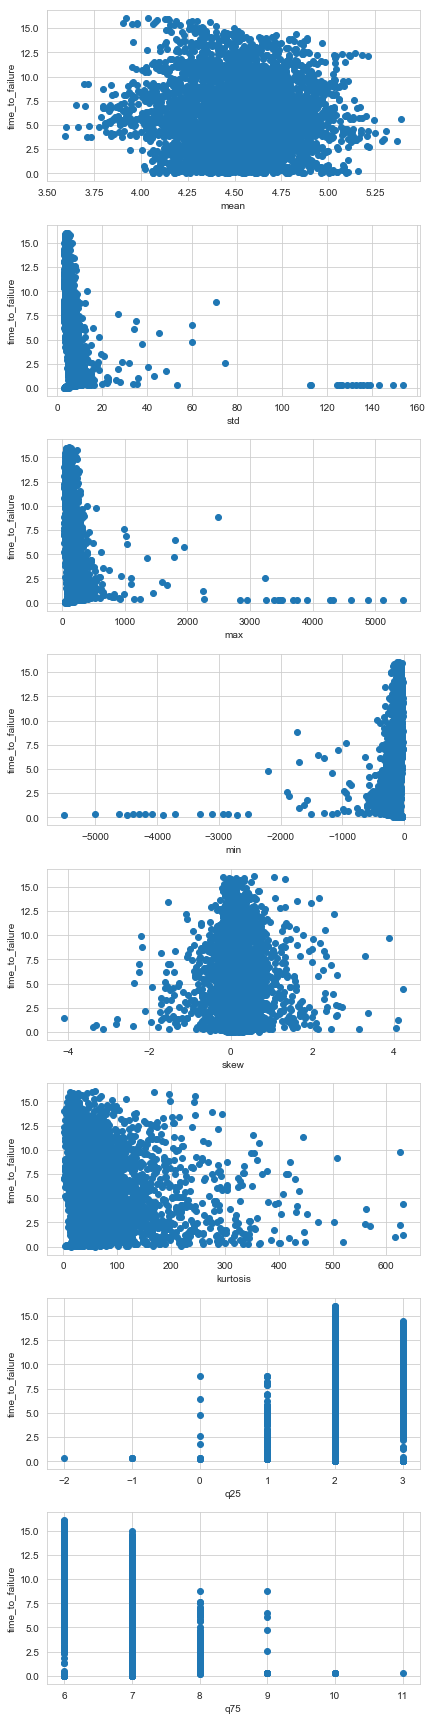

In [4]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,figsize = (6,nrows*3))

for i,axis in enumerate(axes):
    axis.scatter(x_df.iloc[:,i],y_df)
    axis.set_xlabel(x_df.columns[i])
    axis.set_ylabel('time_to_failure')
plt.tight_layout()

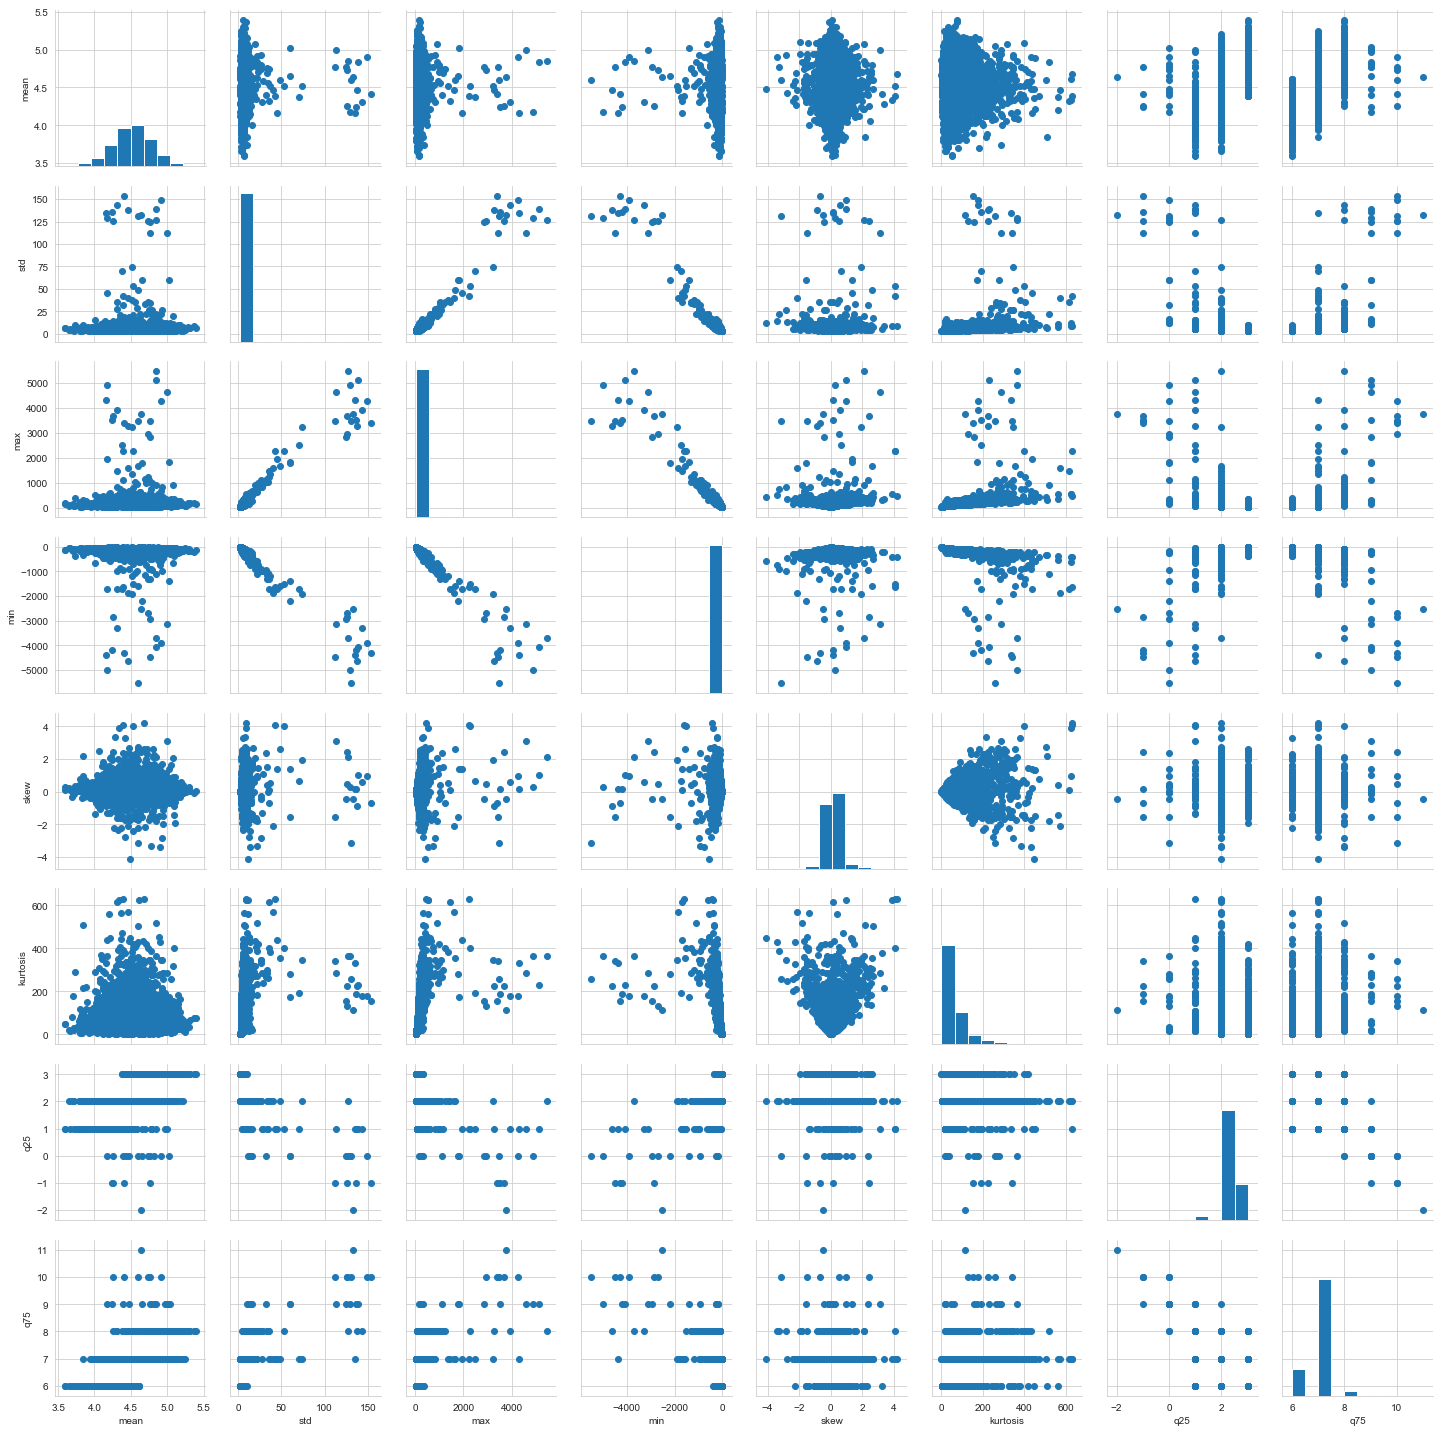

In [5]:
pair_plot = sns.PairGrid(x_df)
pair_plot = pair_plot.map_offdiag(plt.scatter)
pair_plot = pair_plot.map_diag(plt.hist)

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up an Initial model for Random Forest Regressor

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
regressor = RandomForestRegressor(n_estimators=10,max_depth=3,criterion='mae')
res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5)
print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res),np.std(res)))

Mean CV score: -2.235, Std. Dev. of CV scores 0.084


#### 6) Investigate quality of initial model

In [16]:
# Make a final benchmark model by training on the entire training data
from sklearn.base import clone
regressor_final = clone(regressor)
regressor_final = regressor_final.fit(X_train,y_train.values.ravel())

In [17]:
# Plot Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    regressor_final,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

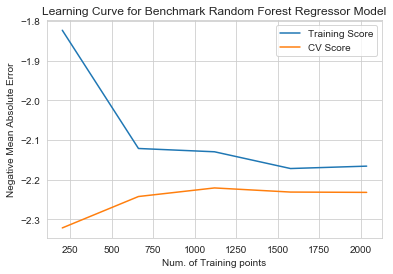

In [18]:
plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for Benchmark Random Forest Regressor Model')

The learning curve shows minimal overfitting since the training and CV curves converge. However, the model underfits the data due to the high (absolute) MAE value.

In [19]:
# Explore the effect of the n_estimators hyperparameter
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(
    regressor_final,X_train,y_train.values.ravel(),
    'n_estimators',[10,25,50,100], cv=4,scoring='neg_mean_absolute_error')

Text(0, 0.5, 'neg_mean_absolute_error ratio')

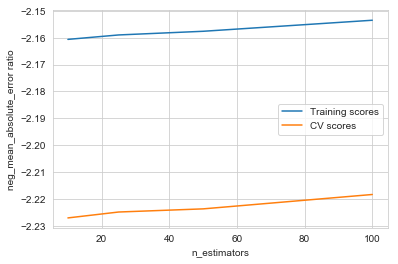

In [22]:
n_estimators = [10,25,50,100]
mean_y = y_train.values.mean()
plt.plot(n_estimators,np.mean(train_scores,axis=1),label='Training scores')
plt.plot(n_estimators,np.mean(valid_scores,axis=1),label='CV scores')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_absolute_error ratio')

#### 7) Set up GridSearchCV to improve model by tuning hyperparameters

In [39]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [3,4,5,6],
          'min_samples_leaf' : [0.05,0.1,0.2],
          'n_estimators' : [10,20,30,60],
          }

grid = GridSearchCV(regressor_final,param_grid=params,scoring='neg_mean_absolute_error',
                   cv = 4)
grid.fit(X_train,y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [0.05, 0.1, 0.2], 'n_estimators': [10, 20, 30, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [40]:
best_regr = grid.best_estimator_
best_regr

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.05, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Text(0, 0.5, 'neg_mean_absolute_error ratio w.r.t mean')

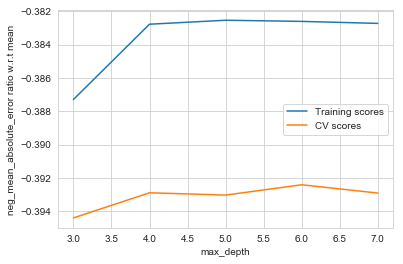

In [41]:
# Explore the effect of the max_depth hyperparameter
train_scores, valid_scores = validation_curve(
    best_regr,X_train,y_train.values.ravel(),
    'max_depth',[3,4,5,6,7], cv=4,scoring='neg_mean_absolute_error')

max_depth = [3,4,5,6,7]
mean_y = y_train.values.mean()
plt.plot(max_depth,np.mean(train_scores,axis=1)/mean_y,label='Training scores')
plt.plot(max_depth,np.mean(valid_scores,axis=1)/mean_y,label='CV scores')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('neg_mean_absolute_error ratio w.r.t mean')

Text(0, 0.5, 'neg_mean_absolute_error ratio w.r.t std')

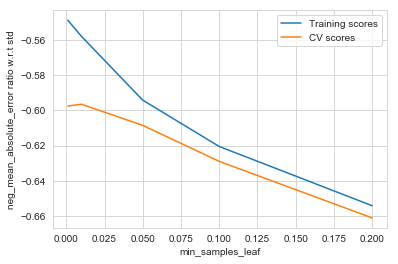

In [42]:
# Explore the effect of the min_samples_leaf hyperparameter
train_scores, valid_scores = validation_curve(
    best_regr,X_train,y_train.values.ravel(),
    'min_samples_leaf',[0.001,0.01,0.05,0.1,0.2], cv=4,scoring='neg_mean_absolute_error')

min_samples_leaf = [0.001,0.01,0.05,0.1,0.2]
mean_y = y_train.values.mean()
std_y = y_train.values.std()
plt.plot(min_samples_leaf,np.mean(train_scores,axis=1)/std_y,label='Training scores')
plt.plot(min_samples_leaf,np.mean(valid_scores,axis=1)/std_y,label='CV scores')
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('neg_mean_absolute_error ratio w.r.t std')

#### 8) Calculate CV and test scores for the optimized Benchmark Random Forest Regressor

In [43]:
print(grid.best_score_)
res2 = cross_val_score(best_regr,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5)
print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res2),np.std(res2)))

-2.2207308902839125
Mean CV score: -2.231, Std. Dev. of CV scores 0.061


In [44]:
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

train_score = mean_absolute_error(y_train,y_train_pred)
test_score = mean_absolute_error(y_test,y_test_pred)

print(train_score)
print(test_score)

2.179349986672742
2.286385213061498


#### 9) Get feature importances and plot the benchmark

In [45]:
for i,j in zip(X_train.columns,best_regr.feature_importances_):
    print("{} : {:.3f}".format(i,j))

mean : 0.001
std : 0.896
max : 0.001
min : 0.001
skew : 0.004
kurtosis : 0.093
q25 : 0.001
q75 : 0.002


In [34]:
benchmark_pred = pd.DataFrame(best_regr.predict(data.iloc[:,:-1]),index=data.index,columns = ['Benchmark Prediction'])

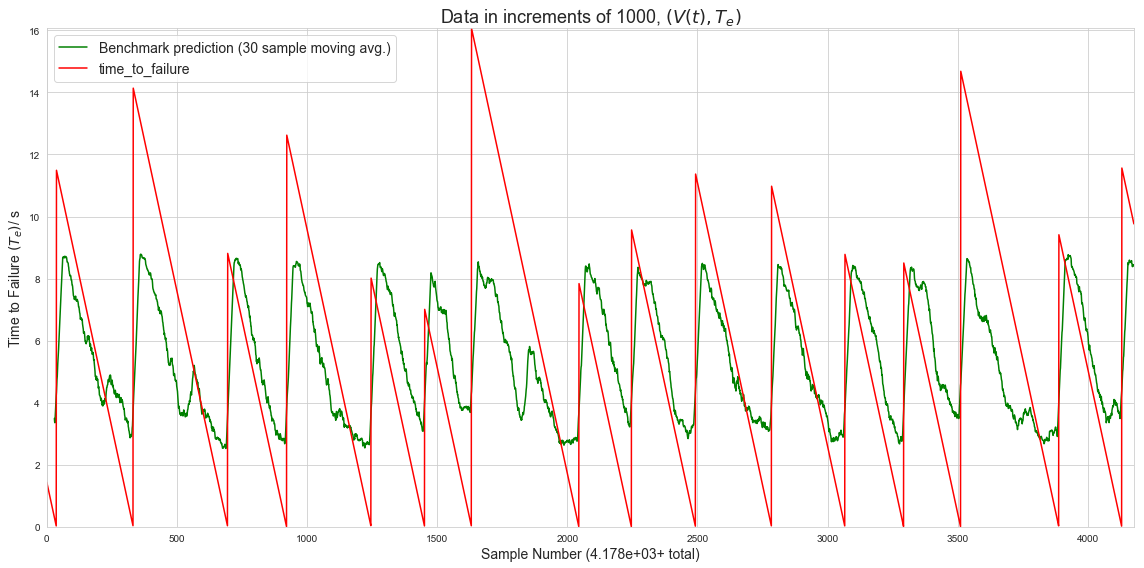

In [38]:
xdata = data.iloc[:,:-1]
fig,axis = plt.subplots(figsize=(16,8))
window = 30
axis.plot(benchmark_pred.rolling(window).mean(),'g',
          label="Benchmark prediction ({} sample moving avg.)".format(window))
axis.plot(data['time_to_failure'],'r')
plt.legend(fontsize=14)
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel(r'Time to Failure $(T_e)$/ s',fontsize=14)
plt.title(r'Data in increments of 1000, $(V(t), T_e)$',fontsize=18)
plt.xlabel(r'Sample Number ({:.3e}+ total)'.format(data.index[-1]),fontsize=14)
plt.tight_layout()
plt.savefig("benchmark_model")

In [48]:
benchmark_pred.to_csv(os.path.join("Data","train_predictions","benchmark_train_pred_fset{}.csv".format(fset)),
                      index=False)

#### 10) Make Kaggle Competition Submission csv

In [37]:
if "submission_features{}.csv".format(fset) not in os.listdir("Features"):
    gen_features.gen_submission_features(gen_features=gen_features.gen_features1,fset=fset)

In [43]:
submission_raw = pd.read_csv(os.path.join("Features","submission_features{}.csv".format(fset))).iloc[:,1:]
submission = pd.concat([submission_raw['seg_id'],
                        pd.Series(best_regr.predict(submission_raw.iloc[:,1:].values),name='time_to_failure')],
                      axis=1)
submission.to_csv(os.path.join("Submissions","Benchmark_fset{}.csv".format(fset)),index=False)